# Wide & Deep Learning for Recommender Systems
- Wide Component와 Deep Component의 장점을 합친 추천 모델
- Wide model
    - memorization(기억)
    - ex) 이전에 먹었던 음식이 '햄버거(bugers)' 이면 불고기버거를 추천해주는 모델. 하지만 같은 패스트푸드인 피자를 추천하지는 못한다.
- Deep model
    - generalization
    - query를 카테고리화 시켜서 그 범주 내에 있는 item을 추천함
    - ex) 위의 예제에서 유저가 햄버거를 클릭, 검색 시 피자를 추천할 수 있음. but, over-generalization 되는 경우가 발생함
    - over-generalization
        - '따뜻한 아메리카노' 검색 시 '커피'라는 일반화 범주에서 '아이스 라떼'를 추천 할 수 있다는 것. 
        - 유저는 따뜻한 음료를 원하고 라떼를 싫어할 수 있지만 전혀 다른 결과를 예측할 수 있는 가능성이 있음.


## References
- [구글에서 발표한 논문](https://arxiv.org/pdf/1606.07792.pdf)
- [텐서플로우 튜토리얼 (tensorflow v1)](https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/tutorials/wide_and_deep/)
- [참고용 소스(tensorflow v2 / gcp api)](https://towardsdatascience.com/how-to-build-a-wide-and-deep-model-using-keras-in-tensorflow-2-0-2f7a236b5a4b)
- [정형 데이터 다루기(feature_column)](https://www.tensorflow.org/tutorials/structured_data/feature_columns?hl=ko)
- [참고 블로그](https://bcho.tistory.com/tag/wide%20and%20deep%20model)

***


## Wide & Deep 모델이란?
- linear 모델의 장점과 neural network(신경망)의 장점을 합치는 모델이다.
- 즉, 선형 모델의 저장법(memorization)과 신경망의 일반화(generalization)의 강점을 합친 모델이다.
- 이 방법은 sparse 입력 feature의 regression 문제와 classification 문제에 유용하다.

### 모델의 3단계 프로세스
1. wide 부분에 대한 features 선택
    - 사용하길 원하는 sparse base column 과 crossed column 들을 선택한다
2. deep 부분에 대한 features 선택 
    - continuous feature(연속된 열), categorical feature(분류 열)의 embedding dimension, 그리고 hidden layer 크기를 선택한다.
3. 이들을 Wide & Deep 모델에 적용한다.

***

# 튜토리얼

## Base Feature Columns 정의
사용할 base categorical feature column 과 continuous feature column 들을 정의하자. 이들 base column 들은 모델의 wide 부분과 deep 부분에 모두 사용될 building block 들이 된다.

In [650]:
import tensorflow as tf
from tensorflow import feature_column as fc

# Categorical base columns. (sparse vector)
real = {
    colname : fc.numeric_column(colname) \
          for colname in \
            ('age,education_num,capital_gain,capital_loss,hours_per_week').split(',')
}
# age_buckets = feature_column.bucketized_column(real['age'], boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
# real.update([age_buckets])
sparse = {
      'gender' : fc.categorical_column_with_vocabulary_list('gender', ["female", "male"]),
      'race' : fc.categorical_column_with_vocabulary_list('race', ["Amer-Indian-Eskimo", "Asian-Pac-Islander", "Black", "Other", "White"]),
      'education' : fc.categorical_column_with_hash_bucket('education', hash_bucket_size=100),
      'marital_status' : fc.categorical_column_with_hash_bucket('marital_status', hash_bucket_size=1000),
      'relationship' : fc.categorical_column_with_hash_bucket('relationship', hash_bucket_size=100),
      'workclass' : fc.categorical_column_with_hash_bucket('workclass', hash_bucket_size=100),
      'occupation' : fc.categorical_column_with_hash_bucket('occupation', hash_bucket_size=1000),
      'native_country'   : fc.categorical_column_with_hash_bucket('native_country', hash_bucket_size=1000)
}

## 모델 생성

### 모델 input 정의

In [651]:

inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') \
          for colname in real.keys()
}
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=( ), dtype='string') \
          for colname in sparse.keys()
})

In [652]:
# cross columns that make sense in combination
# sparse['edu_occ'] = fc.crossed_column([sparse['education'], sparse['occupation']], int(1e4))
# sparse['country_occ'] = fc.crossed_column([sparse['native_country'], sparse['occupation']], int(1e4))
# sparse['age_occ'] =fc.crossed_column([sparse['age_buckets'], sparse['occupation']], int(1e6))

In [653]:
# 임베딩
embed = {
       'embed_{}'.format(colname) : fc.embedding_column(col, 10) \
          for colname, col in sparse.items()
}
real.update(embed)

# one-hot encode the sparse columns
sparse = {
    colname : fc.indicator_column(col) \
          for colname, col in sparse.items()
}

### 레이어 생성

In [654]:
deep = tf.keras.layers.DenseFeatures(real.values())(inputs)
deep = tf.keras.layers.Dense(64, activation='relu')(deep)
deep = tf.keras.layers.Dense(16, activation='relu')(deep)
output = tf.keras.layers.Dense(1, activation='sigmoid')(deep)
model = tf.keras.Model(inputs, output)

In [655]:
def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns)(inputs)
    for numnodes in dnn_hidden_units:
        deep = tf.keras.layers.Dense(numnodes, activation='relu')(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns)(inputs)
    both = tf.keras.layers.concatenate([deep, wide])
    output = tf.keras.layers.Dense(1, activation='sigmoid')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
model = wide_and_deep_classifier(inputs, sparse.values(), real.values(), [64, 16])

In [656]:
model.summary()

Model: "functional_75"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
age (InputLayer)                [(None,)]            0                                            
__________________________________________________________________________________________________
capital_gain (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
capital_loss (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
education (InputLayer)          [(None,)]            0                                            
______________________________________________________________________________________

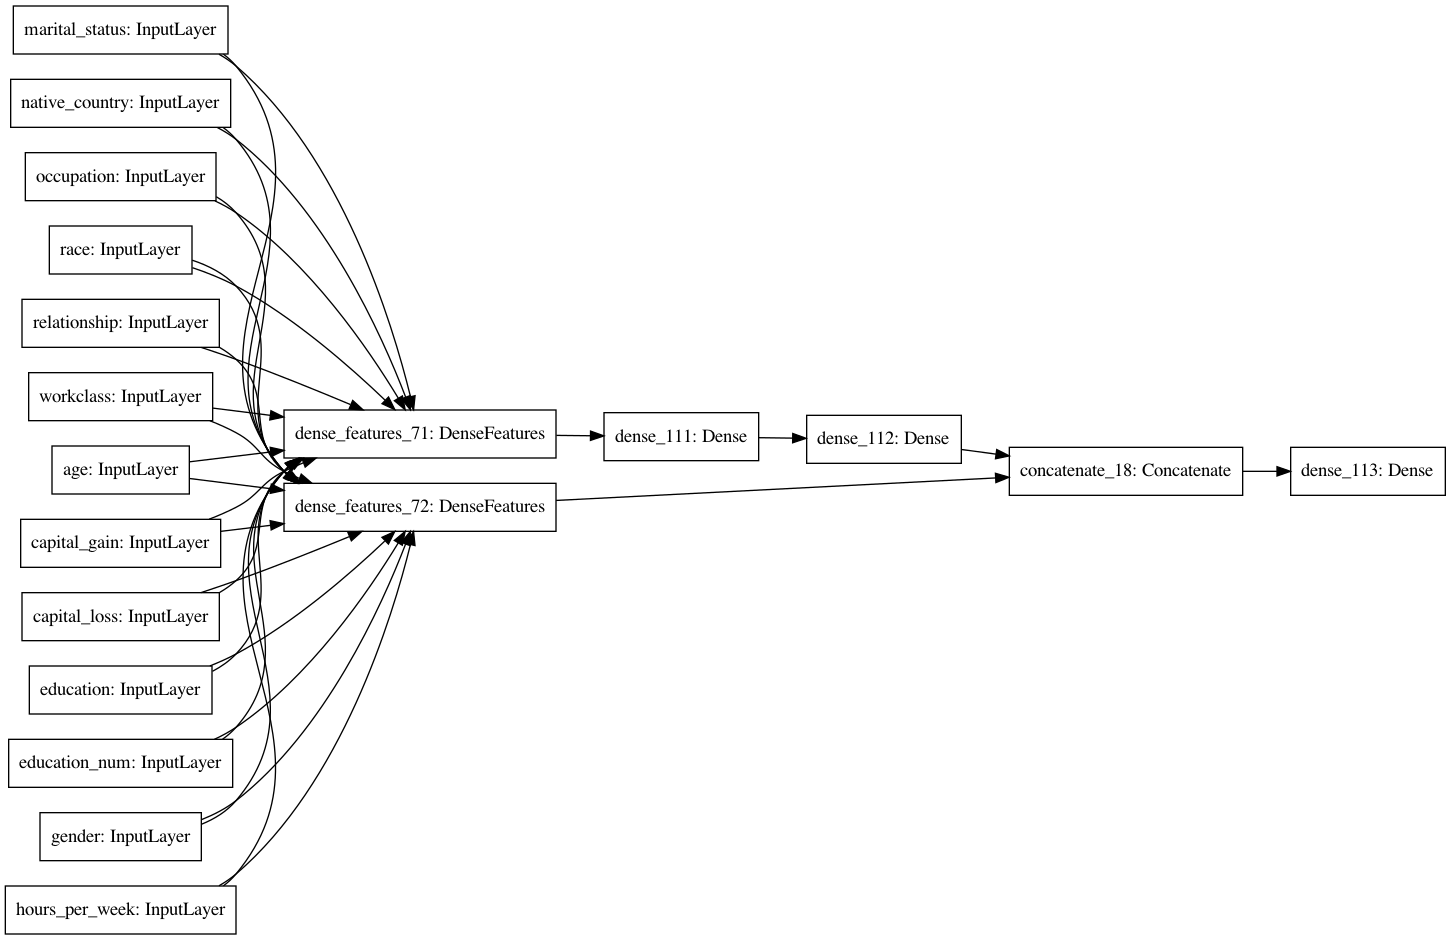

In [657]:
tf.keras.utils.plot_model(model, 'flights_model.png', show_shapes=False, rankdir='LR')


***

## 파라미터 설정

In [658]:
REGION = 'us-central1'
DEVELOP_MODE = True
NBUCKETS = 5 # for embeddings
NUM_EXAMPLES = 1000*1000 # assume 1 million examples
TRAIN_BATCH_SIZE = 64
DNN_HIDDEN_UNITS = '64,32'

TRAIN_DATA = "../dataset/ai-platform_census/adult.data"
TEST_DATA = "../dataset/ai-platform_census/adult.test"

## 데이터 읽기

In [659]:
import pandas as pd

# Define the column names for the data sets.
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
  "marital_status", "occupation", "relationship", "race", "gender",
  "capital_gain", "capital_loss", "hours_per_week", "native_country", "income_bracket"]
LABEL_COLUMN = 'label'
CATEGORICAL_COLUMNS = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "gender", "native_country"]
CONTINUOUS_COLUMNS = ["age", "education_num", "capital_gain", "capital_loss",
                      "hours_per_week"]



# Read the training and test data sets into Pandas dataframe.
df_train = pd.read_csv(TRAIN_DATA, names=COLUMNS, skipinitialspace=True)
df_test = pd.read_csv(TEST_DATA, names=COLUMNS, skipinitialspace=True, skiprows=1)

# label 설정
df_train[LABEL_COLUMN] = (df_train['income_bracket'].apply(lambda x: '>50K' in x)).astype(int)
df_test[LABEL_COLUMN] = (df_test['income_bracket'].apply(lambda x: '>50K' in x)).astype(int)


In [660]:
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [661]:
# 판다스 데이터프레임으로부터 tf.data 데이터셋을 만들기 위한 함수
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('label')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size)
    return ds

In [667]:
from sklearn.model_selection import train_test_split
batch_size = 100 # 예제를 위해 작은 배치 크기를 사용합니다.

train, val = train_test_split(df_train, test_size=0.3)
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, batch_size=batch_size)
test_ds = df_to_dataset(df_test, shuffle=False, batch_size=batch_size)
# print(batch_size)
# train_ds = train_ds.batch(100)
# val_ds = val_ds.batch(100)

In [668]:
for feature_batch, label_batch in train_ds.take(1):
    print('전체 feature:', list(feature_batch.keys()))
    print('나이 feature의 배치:', feature_batch['age'])
    print('label의 배치:', label_batch )

전체 feature: ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income_bracket']
나이 feature의 배치: tf.Tensor(
[41 36 27 43 52 39 33 41 30 21 27 33 41 40 37 56 42 56 33 36 20 40 17 47
 52 34 35 30 25 44 27 32 51 32 62 27 63 42 29 26 39 38 67 62 40 35 59 46
 55 62 35 55 53 31 43 58 31 41 74 47 40 47 42 33 39 27 34 51 39 32 25 70
 59 45 61 20 47 41 49 17 29 25 22 28 35 40 33 33 48 61 29 51 25 55 36 36
 30 34 42 35], shape=(100,), dtype=int64)
label의 배치: tf.Tensor(
[0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0], shape=(100,), dtype=int64)


## 모델 학습

In [669]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)

Epoch 1/5
228/228 [==============================] - 1s 5ms/step - loss: 0.4409 - accuracy: 0.8262 - val_loss: 0.3421 - val_accuracy: 0.8458
Epoch 2/5
228/228 [==============================] - 1s 5ms/step - loss: 0.3414 - accuracy: 0.8437 - val_loss: 0.3268 - val_accuracy: 0.8476
Epoch 3/5
228/228 [==============================] - 1s 5ms/step - loss: 0.3341 - accuracy: 0.8489 - val_loss: 0.3352 - val_accuracy: 0.8390
Epoch 4/5
228/228 [==============================] - 1s 5ms/step - loss: 0.3302 - accuracy: 0.8475 - val_loss: 0.3167 - val_accuracy: 0.8559
Epoch 5/5
228/228 [==============================] - 1s 5ms/step - loss: 0.3277 - accuracy: 0.8481 - val_loss: 0.3264 - val_accuracy: 0.8483
